In [1]:
# Import webdriver from selenium
from selenium import webdriver
import re
import csv
driver = webdriver.Chrome('/Users/Andrew/Desktop/MSBA/chromedriver')

In [2]:
# Have to do first page by itself becuase it does not follow link format
UniqueComments = []
Authors = []
Dates = []
Rows = []
driver.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans")
authors = driver.find_elements_by_class_name('Username')
date = driver.find_elements_by_class_name('Permalink')
posts = driver.find_elements_by_class_name('userContent')
for post in posts:
    for post in posts:
        X = re.search('"(.+)"',post.text)
        if X:
            if X.pos == 0:
                Com = post.text.lstrip(X.group(0))
        else:
            Com = post.text
        UniqueComments.append(Com)
    for a in authors:
        Authors.append(a.text)
    for d in date:
        Dates.append(d.text)

In [3]:
def getPageComments(pagenum):
    site = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(pagenum)
    driver.get(site)
    authors = driver.find_elements_by_class_name('Username') # gets auhtors
    date = driver.find_elements_by_class_name('Permalink') # gets date of comment
    posts = driver.find_elements_by_class_name('Message') # gets comment
    for post in posts:
        X = re.search('"(.+)"',post.text)
        if X:
            if X.pos == 0:
                Com = post.text.lstrip(X.group(0))
        else:
            Com = post.text
        UniqueComments.append(Com)
    for a in authors:
        Authors.append(a.text)
    for d in date:
        Dates.append(d.text)
i = 2
while i < 250:
    getPageComments(i)
    i += 1

In [4]:
print(len(UniqueComments))
print(len(Dates))
print(len(Authors))

8401
8401
8401


In [5]:
a = 0
while a < len(Dates):
    Rows.append((Authors[a],Dates[a],UniqueComments[a].replace('\\',"")))
    a += 1

In [6]:
with open('Edmunds.csv', 'w', encoding = 'UTF-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    a = 0
    while a < len(Dates):
        writer.writerow([Authors[a],Dates[a],UniqueComments[a].replace('\\',"")])
        a += 1

In [15]:
import pandas as pd
from pandas import Series,DataFrame
sedans = pd.read_csv('Edmunds.csv', header = None, names = ["Name","Date","Comment"])
sedans5000 = sedans.sample(n = 5000, random_state = 100)

In [16]:
sedans5000[:5]

,Name,Date,Comment
13894,flightnurse,March 2012,my 2005 330 has one cup holder and I have neve...
3612,buddhabman,August 2004,You ought to read more reviews on the new turb...
8591,fedlawman,January 2007,Only the new Volvo's have Ford DNA in them (mo...
2234,qbrozen,March 2004,nobody is arguing with you that performance is...
1080,wishnhigh1,September 2002,"\n\nWell...yes theoretically speaking, there i..."


In [17]:
from string import punctuation
def clean(x):
    x = str(x)
    x = x.replace('\r', ' ')
    x = x.replace('\n', ' ')
    x = re.sub(r'http://[A-Za-z0-9/.?]*', ' ', x)
    for eachpunc in punctuation:
        x = x.replace(eachpunc, ' ')
    x = re.sub(r'\s+', ' ', x)
    return x.lower()
sedans5000["Comment"] = sedans5000['Comment'].map(clean)

Text(0.5,1,'Top ten luxury brands')

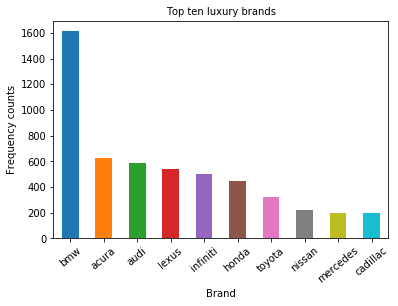

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot
%matplotlib inline

brand_model = pd.read_csv('models.csv')#,header=None,names=["Brand","Model"])
def brandModel(x):
    mention = []
    for i, model in enumerate(brand_model['Model']):
        if model.lower() in x.split(' '):
            mention.append(brand_model['Brand'][i].lower())
    for i, brand in enumerate(brand_model['Brand']):
        if brand.lower() in x.split(' '):
            mention.append(brand.lower())
    return ' '.join(list(set(mention)))
brands = sedans5000["Comment"].map(brandModel)

counter = CountVectorizer()
modelcount = counter.fit_transform(brands).todense()
brands_count = pd.DataFrame(modelcount, columns = counter.get_feature_names(), index = brands.index)
brands_sum = brands_count.sum(axis = 0)
top10 = brands_sum.sort_values(ascending = False)[:10]
top10.plot(kind = 'bar', rot = 40)
pyplot.xlabel('Brand', fontsize = 10)
pyplot.ylabel('Frequency counts', fontsize = 10)
pyplot.title('Top ten luxury brands', fontsize = 10)

In [19]:
def replaceModel(x):
    for i, model in enumerate(brand_model['Model']):
        if model.lower() in x.split(' '):
            x = x.replace(model.lower(), brand_model['Brand'][i].lower())
    return x

brand_comment = sedans5000["Comment"].map(replaceModel)

13894    my 2005 bmw has one cup holder and i have neve...
3612     you ought to read more reviews on the new turb...
8591     only the new volvo s have ford dna in them mos...
2234     nobody is arguing with you that performance is...
1080      well yes theoretically speaking there is a po...
3353     35k for a tl maybe with navi it s a 33k car wi...
15724    now if nissan can shave off 750 pounds from th...
12865    our first and only infiniti thus far is a 2011...
12611    nyc graphicguy makes some good points i m abou...
7807     they forgot some sedans toyota toyota 0 26 lex...
Name: Comment, dtype: object

In [23]:
# A
import itertools
import numpy as np

def a_b_together(x):
    a_b=[]
    for a,b in itertools.combinations(list(top10.index.values),2):
        if a in x.split() and b in x.split():
            if (a,b) not in a_b:
                a_b.append((a,b)) 
    return a_b
t = brand_comment.map(a_b_together)

In [24]:
counts=dict()
for x in t:
    for pair in x:
        counts[pair]=counts.get(pair,0)+1
lift_dict={}
for a,b in itertools.combinations(list(top10.index.values),2):
    lift=5000*counts[(a,b)]/(brands_sum[a]*brands_sum[b])
    lift_dict[(a,b)]=lift

zero=[0,0,0,0,0,0,0,0,0,0]
data={'bmw':zero,'acura':zero,'audi':zero,'lexus':zero,'infiniti':zero,'honda':zero,'toyota':zero,'nissan':zero,'mercedes':zero,'cadillac':zero}
lift_df = DataFrame(data, index=top10.index.values)

for k,v in lift_dict.items():
  lift_df.loc[k[0],k[1]]=v
  lift_df.loc[k[1],k[0]]=v
  lift_df.loc[k[1],k[1]]=np.nan
lift_df

,bmw,acura,audi,lexus,infiniti,honda,toyota,nissan,mercedes,cadillac
bmw,0.000000,1.389060,1.703327,1.885256,1.664948,1.161413,1.492711,1.268892,2.248759,2.036012
acura,1.389060,NaN,2.285279,2.923854,2.808191,2.987137,1.529896,1.933460,2.728732,2.387126
audi,1.703327,2.285279,NaN,2.394304,2.493513,1.178080,1.800847,1.348228,3.855932,3.520209
lexus,1.885256,2.923854,2.394304,NaN,3.621394,1.542001,3.223745,1.900980,4.507435,3.669812
infiniti,1.664948,2.808191,2.493513,3.621394,NaN,1.203541,1.832753,3.388758,3.280318,3.466381
honda,1.161413,2.987137,1.178080,1.542001,1.203541,NaN,3.117993,3.465145,1.849776,1.034840
toyota,1.492711,1.529896,1.800847,3.223745,1.832753,3.117993,NaN,3.977273,3.203125,1.442308
nissan,1.268892,1.933460,1.348228,1.900980,3.388758,3.465145,3.977273,NaN,1.931818,2.097902
mercedes,2.248759,2.728732,3.855932,4.507435,3.280318,1.849776,3.203125,1.931818,NaN,6.410256
cadillac,2.036012,2.387126,3.520209,3.669812,3.466381,1.034840,1.442308,2.097902,6.410256,NaN


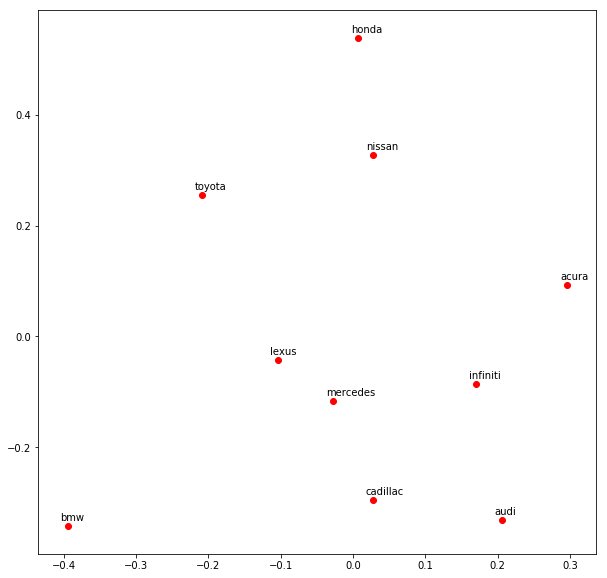

In [25]:
from sklearn import manifold
from matplotlib import pyplot as plt
%matplotlib inline

def calculate_dissimilarity(x):
    if x == 0:
        dissimilarity = 10
    else:
        dissimilarity = 1 / x
    return dissimilarity

dissimilarity = lift_df.applymap(calculate_dissimilarity)
dissimilarity=dissimilarity.fillna(0)

mds = manifold.MDS(n_components = 2, max_iter = 3000, random_state = 50, dissimilarity = 'precomputed')
position = mds.fit(dissimilarity).embedding_
plt.figure(figsize = (10, 10))
plt.scatter(position[:, 0], position[:, 1], color = 'red')
for i, eachpoint in enumerate(position):
    plt.text(eachpoint[0] - 0.01, eachpoint[1] + 0.01, dissimilarity.columns.values[i], fontsize = 10)

In [ ]:
# B

In [26]:
# C 
from nltk.corpus import stopwords

performance = ['problem', 'time', 'drive', 'driving', 'driver', 'problems', 'system', 'issue', 'performance',
              'issues', 'noise', 'speed','control', 'oil', 'steer', 'steering', 'pick-up', 'acceleration']
efficiency = ['miles', 'gas', 'gasoline', 'fuel', 'mileage', 'mpg', 'pump', 'efficient', 'efficiency', 'green', 'environment']
power = ['engine', 'engines', 'transmissions', 'transmission', 'power', 'awd', '4wd', '4x4', '2wd', '4x2', 'mph', 'hp', 'horsepower']
service = ['dealer', 'help', 'service', 'dealership', 'warranty', 'price', 'repair']
part = ['tire', 'tires', 'wheel', 'wheels', 'seat', 'part', 'seats', 'light', 'lights',
      'rear', 'rears', 'front', 'brake', 'package', 'tank', 'window']
safety = ['safe', 'safety', 'airbags', 'airbag', 'seatbelt', 'seatbelts', 'abs', 'skid', 'braking', 'deaths',
          'injury', 'accidents', 'accident', 'tcs', 'antilock braking system', 'traction', 'traction control system', 'dent', 'dents']
cost = ['cost', 'price', 'money', 'insurance', 'expensive', 'costly', 'cheap', 'value', 'worth', 'inexpensive', 'affordable']
aesthetics = ['aesthetics', 'beauty', 'aesthetic', 'beautiful', 'looks', 'design', 'color', 'aerodynamic', 'classy']

def remove_stopword(x):
    xlist = x.strip().split(' ')
    newlist = [word for word in xlist if word not in stopwords.words('english')]
    return newlist

def map_attribute(x):
    word = []
    for eachword in x:
        if eachword in performance:
            word.append('performance')
        elif eachword in efficiency:
            word.append('efficiency')
        elif eachword in power:
            word.append('power')
        elif eachword in service:
            word.append('service')
        elif eachword in part:
            word.append('part')
        elif eachword in safety:
            word.append('safety')
        elif eachword in cost:
            word.append('cost')
        elif eachword in aesthetics:
            word.append('aesthetics')
        else:
            word.append(eachword)
    return ' '.join(list(set(word)))

brand_comment_new = brand_comment.map(remove_stopword)
brand_comment_attribute = brand_comment_new.map(map_attribute)

counter = CountVectorizer()
dtm = counter.fit_transform(brand_comment_attribute).todense()
word = pd.DataFrame(dtm, columns = counter.get_feature_names(), index = brand_comment_attribute.index)
word_count = word.sum(axis = 0).sort_values(ascending = False)
word_count.head(20)

lift_attribute = DataFrame(np.zeros((5, 5)), columns = ['performance', 'power', 'parts', 'service', 'cost'],
                           index = ['bmw', 'acura', 'audi', 'lexus', 'infiniti'])
for i, brand in enumerate(lift_attribute.index):
    sumA = word[brand].sum()
    for j, attribute in enumerate(lift_attribute.columns.values):
        sumB = word[attribute].sum()
        sumAB_ss = word[brand] + word[attribute]
        sumAB = (sumAB_ss == 2).sum()
        lift = 5000 * sumAB / (sumA * sumB)
        lift_attribute.iloc[i, j] = lift
        
lift_attribute

,performance,power,parts,service,cost
bmw,1.249993,1.356254,1.523660,1.580378,1.603028
acura,1.213304,1.576362,1.126412,1.671310,1.556550
audi,1.353755,1.413530,1.635445,1.639374,1.577107
lexus,1.327302,1.408508,1.642683,2.009248,1.983927
infiniti,1.289905,1.464324,2.267099,1.796830,1.927895


The five most frequently mentioned attributes are performance, power, parts, service, and cost.<br>
The five most frequently mentioned brands are BMW, Acura, Audi, Lxus, and Infiniti.<br>
All five brands for all five categories have significant amounts of lift to the point that they are not connected by chance. Consequently, they have significant connections to performance, power, parts, service, and cost. <br>
For performance, Audi has the highest association of all the brands.<br>
For power, Acura has the highest association of all the brand.<br>
For parts, Infinite has the highest association of all the brands.<br>
For service, Lexus has the highest association of all the brands.<br>
For cost, Lexus has the highest association of all the brands.<br>
Most noticeably, Infiniti is highly connected to the attribute 'parts' at a lift ratio of 2.267, while Lexus is highly connected to the attribute 'service' at a lift ratio of 2.009. These are the two highest lift ratios, and they are both coincidentally over a lift ratio of 2. Lexus may be associated with service in perhaps in a positive, negative, or even neutral fashion, but we cannot tell without sentiment analysis, as a Lexus car may require more repairs, help, or assistance with warranty. Alternatively, they may have excellent services in general. The same reasoning can be applied to Infiniti with parts, as they may be associated with faulty parts or perhaps parts of good quality. What we know is that they have unusually high lift ratios compared to other brands for these two attributes.<br>
On the other hand, BMW is not the most mentioned in any of these attributes. It is hard to judge whether the public agrees that it is the 'ultimate driving machine' without sentiment analysis, however, the fact that they are not as strongly connected to peprformance, power, parts, and so on indicate they may not be on as many people's radar like Lexus, Infiniti, or Audi is. In fact, every brand except Acura has a higher lift ratio in every attribute than BMW. Assuming we are basing this judgment off of mentions alone, we can conclude BMW is not the 'ultimate driving machine' relative to other brands mentioned here.

In [ ]:
# D

In [27]:
# E
lift_attribute = DataFrame(np.zeros((10,8)), columns = ['performance', 'power', 'part', 'service', 'cost','aesthetics','safety', 'efficiency'],
                           index = ['bmw', 'acura', 'audi', 'lexus', 'infiniti','honda','cadillac','mercedes','nissan','toyota'])

for i, brand in enumerate(lift_attribute.index):
    sumA = word[brand].sum()
    for j, attribute in enumerate(lift_attribute.columns.values):
        sumB = word[attribute].sum()
        sumAB_ss = word[brand] + word[attribute]
        sumAB = (sumAB_ss == 2).sum()
        lift = 5000 * sumAB / (sumA * sumB)
        lift_attribute.iloc[i, j] = lift
        
display(lift_attribute)

print(lift_attribute.mean(axis = 1).sort_values(ascending = False))

,performance,power,part,service,cost,aesthetics,safety,efficiency
bmw,1.249993,1.356254,1.317527,1.580378,1.603028,1.442106,1.135172,1.297361
acura,1.213304,1.576362,1.450513,1.671310,1.556550,1.563445,1.572041,1.350475
audi,1.353755,1.413530,1.539418,1.639374,1.577107,1.959058,1.397868,1.385267
lexus,1.327302,1.408508,1.357248,2.009248,1.983927,1.410574,1.110081,1.095386
infiniti,1.289905,1.464324,1.276743,1.796830,1.927895,1.161860,0.768584,1.146964
honda,1.316229,1.340751,1.483461,1.466823,1.568478,1.489336,2.068949,1.874559
cadillac,1.383627,1.219098,1.199718,1.517862,1.839715,2.530803,1.321702,0.534188
mercedes,1.284797,1.363991,1.444954,1.955603,1.485426,1.493506,1.932990,1.201923
nissan,1.411330,1.611989,1.417848,1.537574,1.375866,1.534829,1.171509,1.821096
toyota,1.385149,1.517689,1.559330,1.936240,1.923959,2.014487,1.105781,1.533807


toyota      1.622055
honda       1.576073
audi        1.533172
mercedes    1.520399
acura       1.494250
nissan      1.485255
lexus       1.462785
cadillac    1.443339
bmw         1.372727
infiniti    1.354138
dtype: float64


In [28]:
aspiration_list = ['dream', 'expect', 'wish', 'hope', 'want', 'wanted', 'buy', 
             'purchase', 'consider', 'considered', 'desire', 'desired',
              'like', 'would', 'goal', 'ideal', 'love','steal','afford','opportunity']

aspiration_lift_matrix = DataFrame(np.zeros((10, 20)), columns = aspiration_list, index = lift_df.index)
for i, brand in enumerate(aspiration_lift_matrix.index):
    sumA = word[brand].sum()
    for j, aspiration in enumerate(aspiration_lift_matrix.columns.values):
        sumB = word[aspiration].sum()
        sumAB = ((word[brand] + word[aspiration]) == 2).sum()
        lift = 5000 * sumAB / (sumA * sumB)
        aspiration_lift_matrix.iloc[i, j] = lift
display(aspiration_lift_matrix)
print(aspiration_lift_matrix.sum(axis = 1).sort_values(ascending = False))

,dream,expect,wish,hope,want,wanted,buy,purchase,consider,considered,desire,desired,like,would,goal,ideal,love,steal,afford,opportunity
bmw,1.550868,1.505255,1.184300,1.375553,1.387457,1.603440,1.536306,1.033912,1.723187,1.335470,1.920123,1.240695,1.378550,1.351513,1.772421,1.993974,1.494981,3.101737,1.635461,1.772421
acura,2.407705,1.298272,1.167372,1.395771,1.356229,1.768371,1.337614,2.257223,1.486237,2.563760,1.910877,3.210273,1.446604,1.570242,1.146526,2.866315,2.169103,0.000000,1.459215,1.146526
audi,0.847458,1.869392,1.078582,2.358143,1.667958,2.154553,1.531790,1.147599,2.092488,1.883239,1.614205,3.389831,1.457767,1.561949,1.210654,1.210654,2.061383,0.470810,0.924499,2.421308
lexus,0.936330,1.376955,1.532176,2.524019,1.600882,1.666349,1.956182,1.950687,2.080732,1.560549,1.783485,5.617978,1.502751,1.495649,2.675227,2.675227,1.391841,0.520183,1.191692,1.337614
infiniti,0.000000,1.900363,1.626604,2.593137,1.600734,1.769047,1.773397,1.346090,2.270329,1.932847,0.000000,1.988072,1.276293,1.418709,2.130077,2.130077,1.791055,0.552242,0.361468,2.130077
honda,1.146789,1.180518,1.042535,0.897487,1.459135,1.652154,1.453676,2.986430,1.486578,3.344801,0.546090,6.880734,1.481859,1.560847,0.819135,2.457405,2.169601,0.000000,1.668057,0.819135
toyota,0.000000,1.941371,2.400240,4.448271,1.705936,2.377356,2.246704,1.031353,3.055861,2.291896,0.000000,0.000000,1.629793,1.512911,0.000000,3.536068,1.114976,0.000000,1.800180,0.000000
nissan,0.000000,3.008021,1.652893,1.778656,2.078438,3.081664,1.440461,1.183712,1.262626,3.787879,2.164502,0.000000,1.496446,1.417769,0.000000,0.000000,1.638002,0.000000,1.652893,1.623377
mercedes,0.000000,2.205882,1.818182,2.826087,1.242545,1.694915,1.584507,1.302083,1.851852,1.041667,0.000000,0.000000,1.522634,1.488658,3.571429,1.785714,1.126126,0.000000,2.272727,1.785714
cadillac,0.000000,1.131222,0.466200,0.445931,1.682214,1.303781,1.263994,0.267094,1.424501,0.712251,1.221001,5.128205,1.456157,1.599535,7.326007,0.000000,0.693001,0.000000,1.864802,1.831502


lexus       37.376508
honda       35.052966
acura       33.964234
audi        32.954261
bmw         31.897625
toyota      31.092916
infiniti    30.590616
cadillac    29.817399
nissan      29.267339
mercedes    29.120722
dtype: float64


For our analysis, we used words that we typically associate with aspiration to create an aspiration lift matrix. Once we had our matrix, we added up all of the lifts and saw which brand had the highest total aspirational lift.

Apparently, people in our forum want to buy Lexus Automobiles. This could be because of the service they provide, or it could be because of their amazing sound systems. Whatever it is, Lexus can take advantage of these insights by examining their closest competitor (Mercedes) and explaining what they do better than them. They could also spend time improving the things that Mercedes does better than them. For example, people are more likely to equate safety with Mercedes instead of Lexus, so they could spend some time bolstering their safety features. Also, Lexus probably shouldn't try to alter their costs even though people talk about it more than they talk about the cost of a Mercedes. This is because the high cost of their cars could be one of the things that drives up the desirability of their vehicles. People often associate price with value, so that could very well be what's happening in this case.

Also, we thought it was interesting how the word 'steal' mostly applies to the more high-end cars in our dataset. 😁